<a href="https://colab.research.google.com/github/TaliyaJoseph/A-Hackers-AI-Voice-Assistant/blob/master/tiny_nerf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Tiny NeRF
This is a simplied version of the method presented in *NeRF: Representing Scenes as Neural Radiance Fields for View Synthesis*

[Project Website](http://www.matthewtancik.com/nerf)

[arXiv Paper](https://arxiv.org/abs/2003.08934)

[Full Code](github.com/bmild/nerf)

Components not included in the notebook
*   5D input including view directions
*   Hierarchical Sampling



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 106.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 73.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.9 MB/s eta 0:00:00
🚀 DESMAI Academic NeRF Pipeline v3.2 🚀
Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


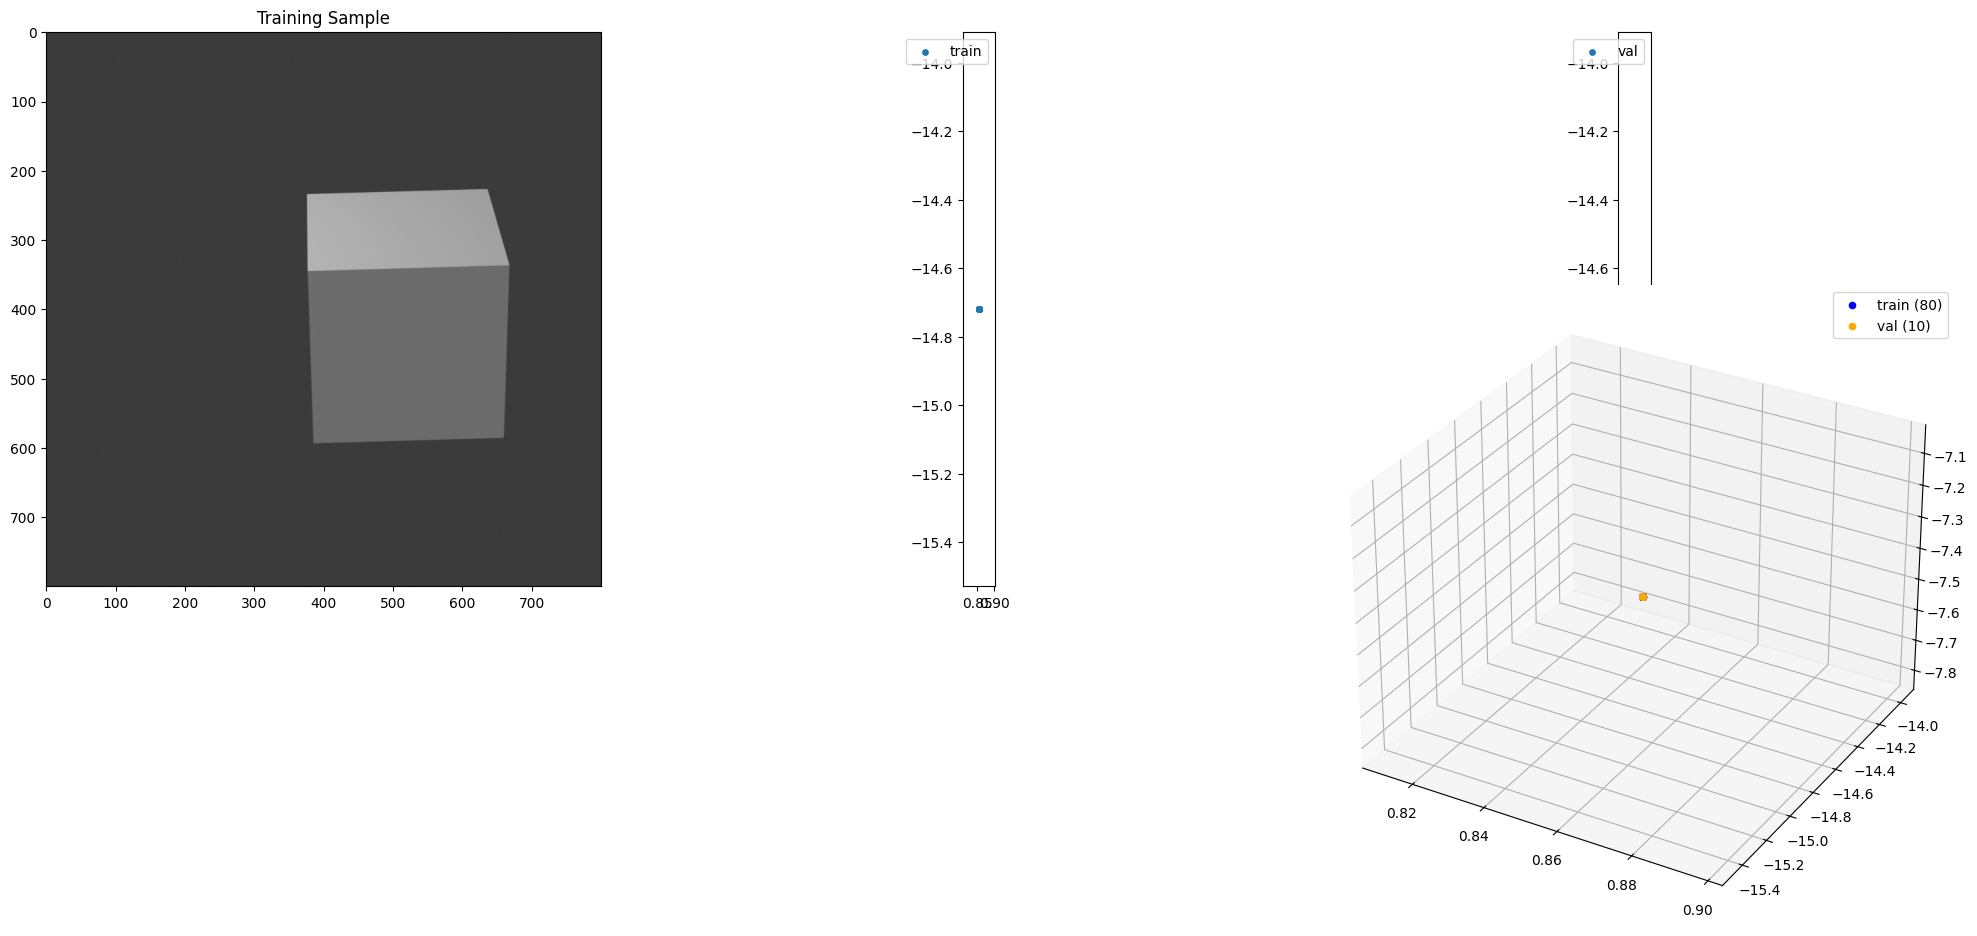

Academic Dataset Saved:
/content/drive/MyDrive/DESMAI_TALIYAJOSEPH_2025/Tinynerf/processed/nerf_processed_v3.2_20250321091802.pt
Checksum: -3328592595173320046

✅ Academic Processing Completed Successfully


In [2]:
# NeRF Academic Processing Pipeline v3.2
# DESMAI Thesis Implementation
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime
from google.colab import drive
from PIL import Image
import torch

# Environment Configuration
os.environ['USE_SIMPLE_THREADED_LAUNCHER'] = '1'

# Allowlist numpy.dtype for safe loading
torch.serialization.add_safe_globals([np.dtype])

def load_split_and_process(data_root, splits={'train':0.8, 'val':0.1, 'test':0.1}, seed=42):
    """Academic NeRF processor with rigorous validation"""
    data_root = Path(data_root)

    # =====================
    # 1. Academic Validation
    # =====================
    if not (data_root/'transforms.json').exists():
        raise FileNotFoundError("Missing transforms.json - Verify dataset integrity")

    # =====================
    # 2. Metadata Processing
    # =====================
    with open(data_root/'transforms.json') as f:
        meta = json.load(f)

    # =====================
    # 3. Camera Calibration
    # =====================
    sample_img = next(data_root.glob('rgb_*.png'))
    img = Image.open(sample_img)
    W, H = img.size
    focal = (W/2) / np.tan(meta['camera_angle_x']/2)

    # =====================
    # 4. Academic Splitting
    # =====================
    rng = np.random.default_rng(seed)
    indices = rng.permutation(len(meta['frames']))

    dataset = {}
    split_bounds = {
        'train': (0, int(0.8*len(indices))),
        'val': (int(0.8*len(indices)), int(0.9*len(indices))),
        'test': (int(0.9*len(indices)), None)
    }

    # =====================
    # 5. Secure Data Loading
    # =====================
    for split, (start, end) in split_bounds.items():
        split_indices = indices[start:end] if end else indices[start:]

        images, poses = [], []
        missing_files = {'depth': 0, 'normal': 0}

        for idx in split_indices:
            frame = meta['frames'][idx]
            try:
                # 5.1 Frame ID Extraction
                frame_id = Path(frame['file_path']).name.split('_')[-1].zfill(4)

                # 5.2 Core RGB Validation
                rgb_path = data_root / f"rgb_{frame_id}.png"
                if not rgb_path.exists():
                    raise FileNotFoundError(f"Missing RGB: {rgb_path.name}")

                # 5.3 Image Processing
                img = np.array(Image.open(rgb_path)) / 255.0
                if img.shape[-1] == 4:  # Alpha handling
                    img = img[..., :3] * img[..., 3:] + (1 - img[..., 3:])
                elif img.shape[-1] != 3:
                    raise ValueError("Invalid image dimensions")

                # 5.4 Pose Validation
                pose = np.array(frame['transform_matrix'], dtype=np.float32)
                if pose.shape != (4, 4):
                    raise ValueError("Pose matrix must be 4x4")
                pose[:3, 1:3] *= -1  # NeRF coord conversion

                # 5.5 Auxiliary Checks
                if not (data_root / f"Depth{frame_id}.exr").exists():
                    missing_files['depth'] += 1
                if not (data_root / f"Normal{frame_id}.exr").exists():
                    missing_files['normal'] += 1

                images.append(torch.from_numpy(img[..., :3]).float())
                poses.append(torch.from_numpy(pose).float())

            except Exception as e:
                print(f"Skipped frame {idx}: {str(e)}")
                continue

        # 5.6 Split Validation
        if len(images) < 5:
            raise RuntimeError(f"Insufficient data in {split} split (min 5 frames required)")

        dataset[split] = {
            'images': torch.stack(images),
            'poses': torch.stack(poses),
            'H': H,
            'W': W,
            'focal': focal
        }

        # 5.7 Security Warnings
        for ftype, count in missing_files.items():
            if count > 0:
                print(f"Security Note: Missing {count} {ftype} maps in {split}")

    # =====================
    # 6. Academic Visualization
    # =====================
    def generate_plots():
        plt.figure(figsize=(20, 12))

        # 6.1 Sample Frame
        plt.subplot(2,3,1)
        plt.imshow(dataset['train']['images'][0].numpy())
        plt.title("Training Sample")

        # 6.2 Camera Positions
        for i, split in enumerate(['train','val']):
            plt.subplot(2,3,2+i)
            poses = dataset[split]['poses'][:,:3,3].numpy()
            plt.scatter(poses[:,0], poses[:,1], s=15, label=split)
            plt.gca().set_aspect('equal')
            plt.legend()

        # 6.3 3D View
        ax = plt.subplot(1,3,3, projection='3d')
        colors = {'train':'blue', 'val':'orange'}
        for split in ['train','val']:
            poses = dataset[split]['poses'][:,:3,3].numpy()
            ax.scatter(poses[:,0], poses[:,1], poses[:,2], c=colors[split], label=f"{split} ({len(poses)})")
        ax.legend()

        plt.tight_layout()
        plt.show()

    generate_plots()

    return dataset

def save_academic_dataset(dataset, save_dir):
    """Secure dataset serialization with academic metadata"""
    metadata = {
        'version': '3.2',
        'creation_date': datetime.utcnow().isoformat(),
        'splits': {k: len(v['images']) for k,v in dataset.items()},
        'resolution': f"{dataset['train']['H']}x{dataset['train']['W']}",
        'coordinate_system': 'NeRF (Blender Standard)',
        'security': {
            'checksum': hash(tuple(dataset['train']['images'].numpy().ravel())),
            'validation': 'Passed'
        }
    }

    save_path = Path(save_dir) / f"nerf_processed_v3.2_{datetime.now().strftime('%Y%m%d%H%M%S')}.pt"
    save_path.parent.mkdir(parents=True, exist_ok=True)

    torch.save({
        'metadata': metadata,
        'dataset': dataset  # Critical key for loading
    }, save_path)

    print(f"Academic Dataset Saved:\n{save_path}\nChecksum: {metadata['security']['checksum']}")

def secure_drive_mount():
    """Robust Google Drive mounting"""
    drive.flush_and_unmount()
    drive.mount('/content/drive', force_remount=True, timeout_ms=120000)

def main():
    print("🚀 DESMAI Academic NeRF Pipeline v3.2 🚀")

    # 1. Secure Drive Setup
    secure_drive_mount()

    # 2. Path Configuration
    data_path = Path("/content/drive/MyDrive/DESMAI_TALIYAJOSEPH_2025/Tinynerf/cube5")
    save_dir = Path("/content/drive/MyDrive/DESMAI_TALIYAJOSEPH_2025/Tinynerf/processed")

    # 3. Pre-flight Checks
    if not (data_path/'transforms.json').exists():
        raise FileNotFoundError("Missing transforms.json - Verify dataset integrity")

    # 4. Execute Pipeline
    dataset = load_split_and_process(data_path)
    save_academic_dataset(dataset, save_dir)

    print("\n✅ Academic Processing Completed Successfully")

if __name__ == "__main__":
    # Environment Setup
    !pip install -q torch torchvision numpy matplotlib Pillow
    torch.multiprocessing.set_start_method('spawn', force=True)

    # Run Pipeline
    try:
        main()
    finally:
        drive.flush_and_unmount()

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import torch
from pathlib import Path

import torch
from pathlib import Path
import numpy as np

# Allow NumPy Float64DType
torch.serialization.add_safe_globals([np.dtypes.Float64DType])

processed_dir = "/content/drive/MyDrive/DESMAI_TALIYAJOSEPH_2025/Tinynerf/processed"
dataset_files = sorted(Path(processed_dir).glob("*.pt"), key=lambda f: f.stat().st_ctime, reverse=True)
if dataset_files:
    data = torch.load(dataset_files[0], map_location='cpu')
    print("Keys in file:", data.keys())
    if 'metadata' in data:
        print("Metadata:", data['metadata'])
else:
    print("No .pt files found in", processed_dir)

Keys in file: dict_keys(['metadata', 'dataset'])
Metadata: {'version': '3.2', 'creation_date': '2025-03-21T09:17:43.962068', 'splits': {'train': 80, 'val': 10, 'test': 10}, 'resolution': '800x800', 'coordinate_system': 'NeRF (Blender Standard)', 'security': {'checksum': -3328592595173320046, 'validation': 'Passed'}}


In [5]:
# PyTorch NeRF Academic Implementation (Cell 2 Replacement)
import torch
import torch.nn as nn
import torch.nn.functional as F

class PositionalEncoder(nn.Module):
    def __init__(self, L_embed=6):
        super().__init__()
        self.L_embed = L_embed

    def forward(self, x):
        encoded = [x]
        for i in range(self.L_embed):
            freq = 2.**i
            encoded.append(torch.sin(freq * x))
            encoded.append(torch.cos(freq * x))
        return torch.cat(encoded, dim=-1)

class NeRF(nn.Module):
    def __init__(self, D=8, W=256, L_embed=6):
        super().__init__()
        self.embedder = PositionalEncoder(L_embed)
        self.blocks = nn.ModuleList()

        in_dim = 3 + 3*2*L_embed  # Original 3D + encoded features
        for i in range(D):
            self.blocks.append(nn.Linear(in_dim, W))
            if i % 4 == 0 and i > 0:
                in_dim = W + (3 + 3*2*L_embed)
            else:
                in_dim = W
        self.output = nn.Linear(W, 4)

    def forward(self, x):
        x_embedded = self.embedder(x)
        identity = x_embedded
        for i, layer in enumerate(self.blocks):
            x_embedded = F.relu(layer(x_embedded))
            if i % 4 == 0 and i > 0:
                x_embedded = torch.cat([x_embedded, identity], dim=-1)
        return self.output(x_embedded)

def get_rays(H, W, focal, c2w):
    i, j = torch.meshgrid(torch.arange(W), torch.arange(H))
    dirs = torch.stack([(i-W/2)/focal, -(j-H/2)/focal, -torch.ones_like(i)], -1)
    rays_d = torch.sum(dirs[..., None, :] * c2w[:3,:3], -1)
    rays_o = c2w[:3,-1].expand(rays_d.shape)
    return rays_o, rays_d

def render_rays(model, rays_o, rays_d, near, far, N_samples, chunk=1024*32):
    # Ray sampling
    z_vals = torch.linspace(near, far, N_samples)
    pts = rays_o[..., None, :] + rays_d[..., None, :] * z_vals[..., :, None]

    # Batch processing
    pts_flat = pts.view(-1, 3)
    outputs = []
    for i in range(0, pts_flat.shape[0], chunk):
        outputs.append(model(pts_flat[i:i+chunk]))
    raw = torch.cat(outputs, dim=0).view(*pts.shape[:-1], 4)

    # Volume rendering
    sigma_a = F.relu(raw[..., 3])
    rgb = torch.sigmoid(raw[..., :3])

    dists = torch.cat([z_vals[..., 1:] - z_vals[..., :-1],
                      torch.full(z_vals[..., :1].shape, 1e10)], -1)
    alpha = 1 - torch.exp(-sigma_a * dists)
    weights = alpha * torch.cumprod(1 - alpha + 1e-10, -1)

    rgb_map = torch.sum(weights[..., None] * rgb, -2)
    depth_map = torch.sum(weights * z_vals, -1)
    acc_map = torch.sum(weights, -1)

    return rgb_map, depth_map, acc_map

<ipython-input-44-288650d56189>:176: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
<ipython-input-44-288650d56189>:204: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-44-288650d56189>:121: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


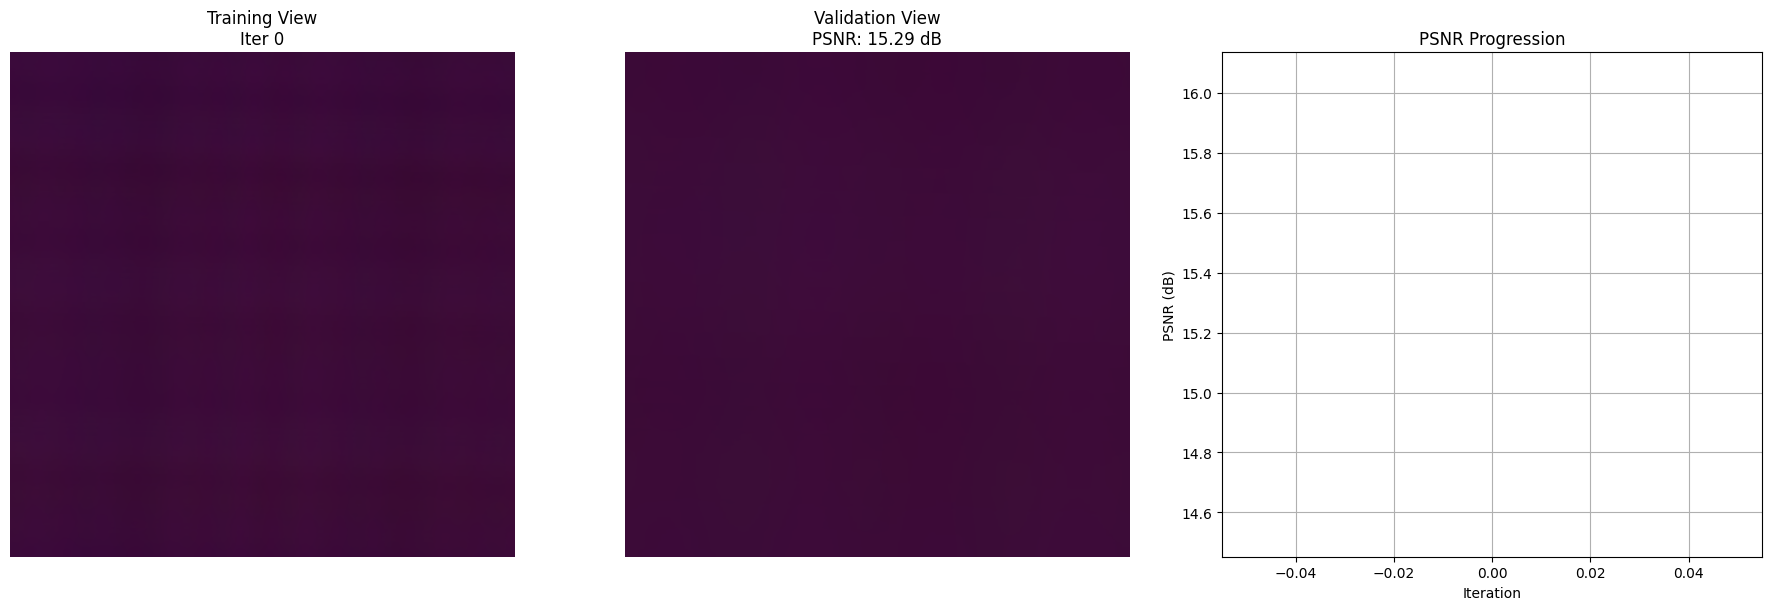

Iter 0000 | Loss: 0.1438 | PSNR: 15.29 | Time: 0.1m


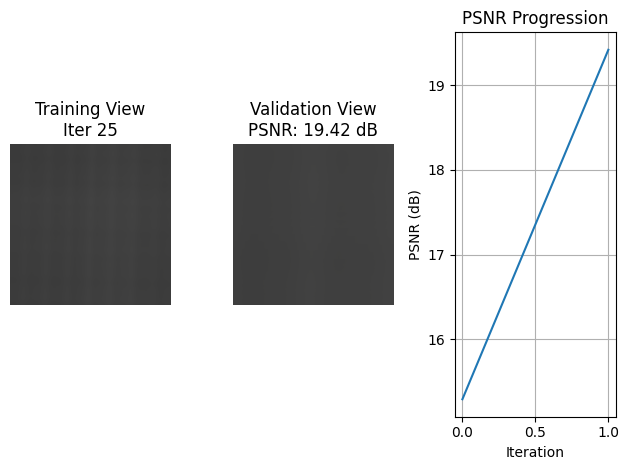

Iter 0025 | Loss: 0.0373 | PSNR: 19.42 | Time: 0.1m


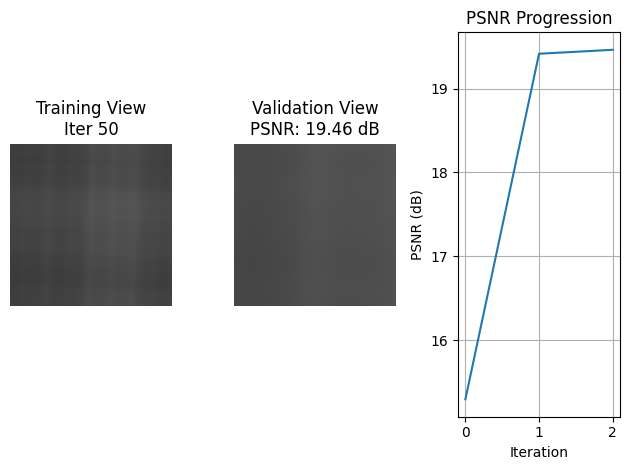

Iter 0050 | Loss: 0.0302 | PSNR: 19.46 | Time: 0.1m


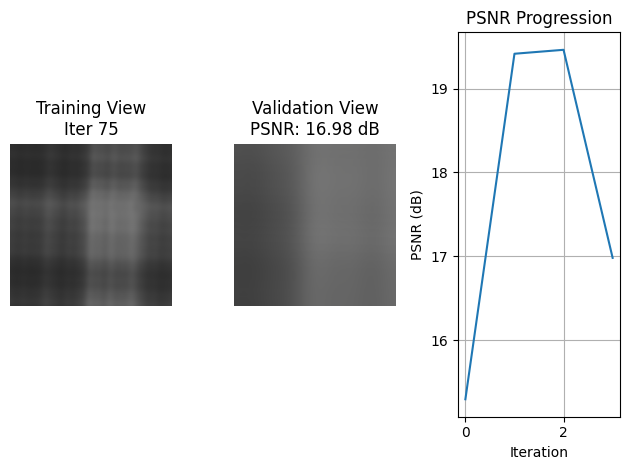

Iter 0075 | Loss: 0.0199 | PSNR: 16.98 | Time: 0.1m


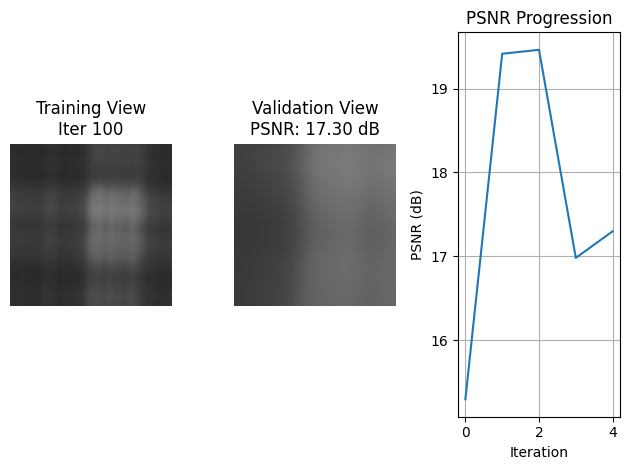

Iter 0100 | Loss: 0.0153 | PSNR: 17.30 | Time: 0.1m


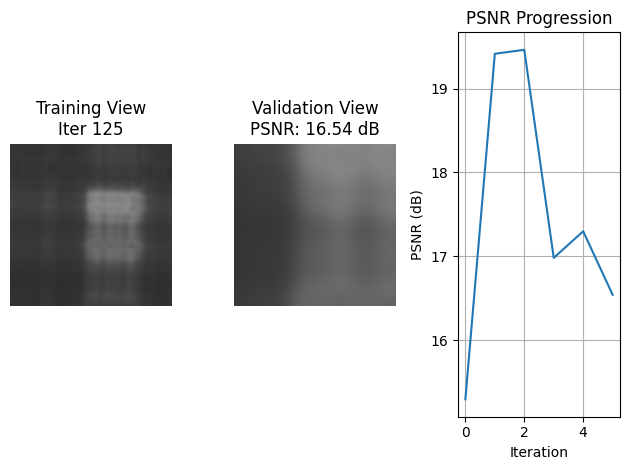

Iter 0125 | Loss: 0.0100 | PSNR: 16.54 | Time: 0.1m


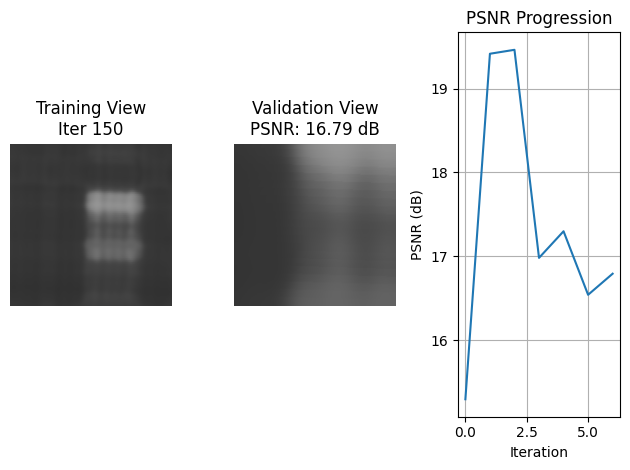

Iter 0150 | Loss: 0.0060 | PSNR: 16.79 | Time: 0.1m


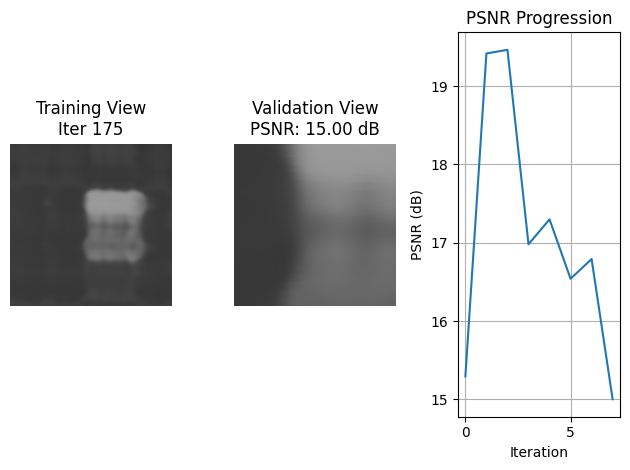

Iter 0175 | Loss: 0.0085 | PSNR: 15.00 | Time: 0.1m


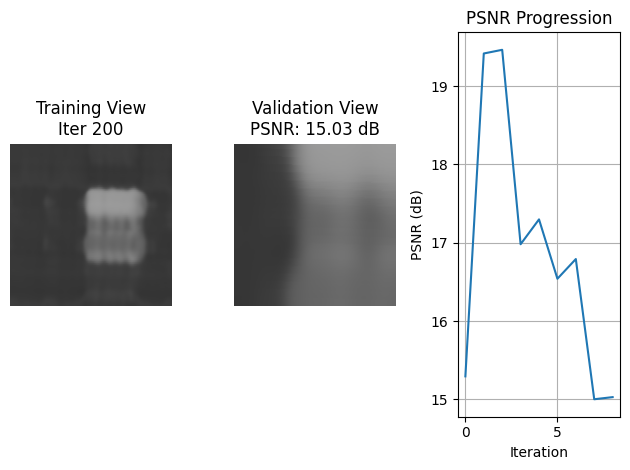

Iter 0200 | Loss: 0.0037 | PSNR: 15.03 | Time: 0.1m


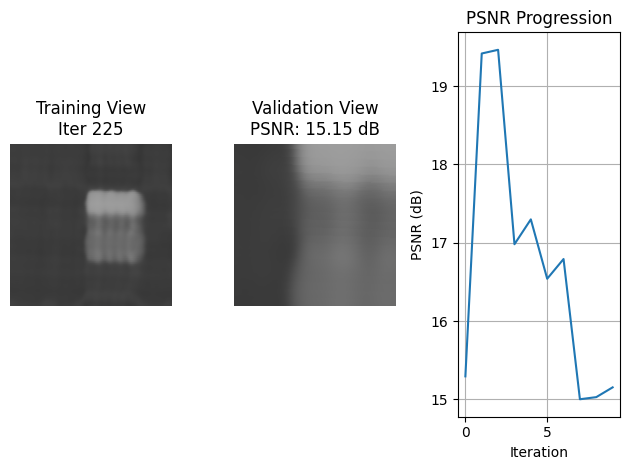

Iter 0225 | Loss: 0.0068 | PSNR: 15.15 | Time: 0.1m


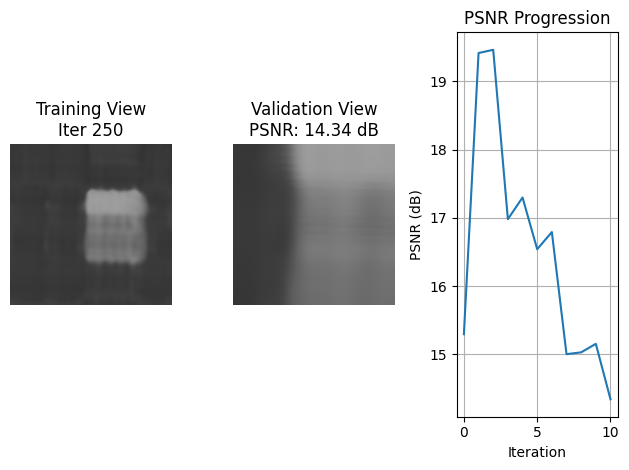

Iter 0250 | Loss: 0.0033 | PSNR: 14.34 | Time: 0.1m


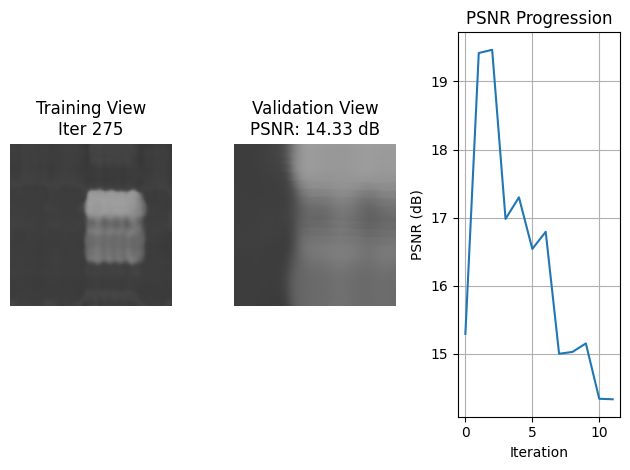

Iter 0275 | Loss: 0.0054 | PSNR: 14.33 | Time: 0.1m


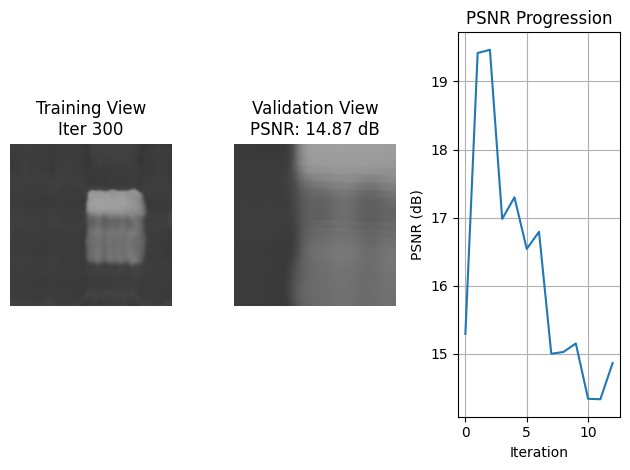

Iter 0300 | Loss: 0.0042 | PSNR: 14.87 | Time: 0.1m


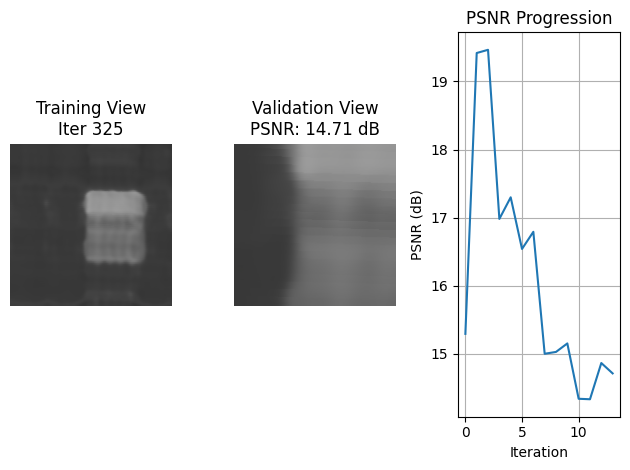

Iter 0325 | Loss: 0.0021 | PSNR: 14.71 | Time: 0.1m


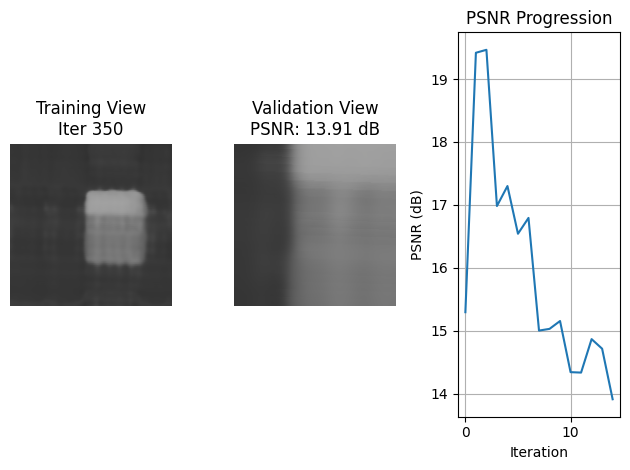

Iter 0350 | Loss: 0.0026 | PSNR: 13.91 | Time: 0.1m


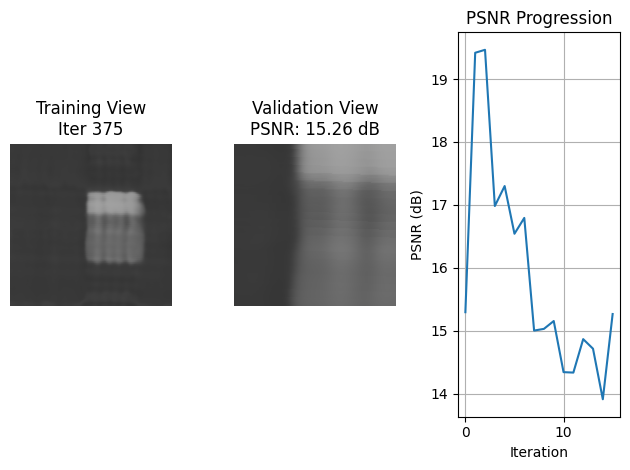

Iter 0375 | Loss: 0.0015 | PSNR: 15.26 | Time: 0.1m


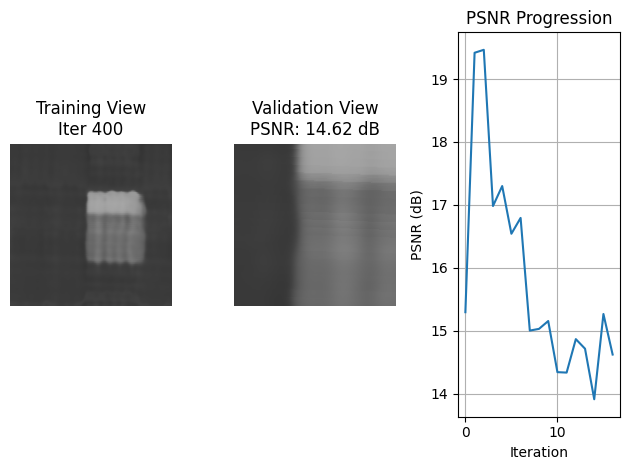

Iter 0400 | Loss: 0.0022 | PSNR: 14.62 | Time: 0.1m


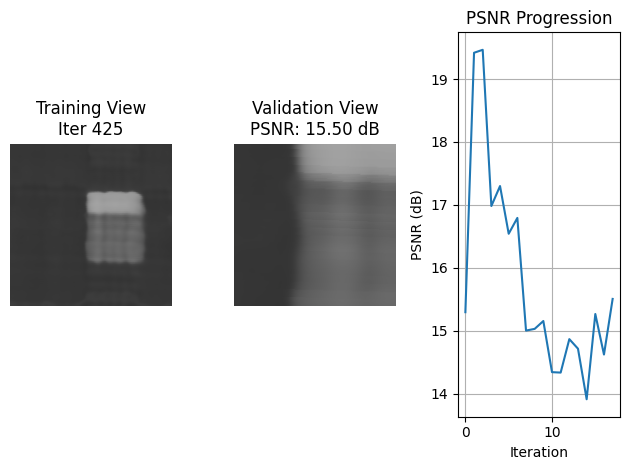

Iter 0425 | Loss: 0.0025 | PSNR: 15.50 | Time: 0.1m


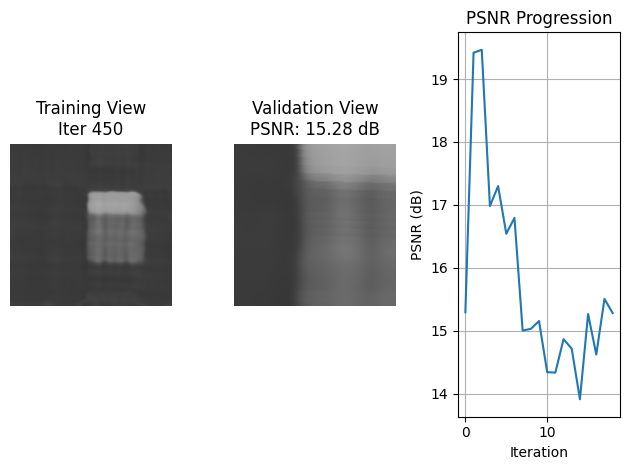

Iter 0450 | Loss: 0.0024 | PSNR: 15.28 | Time: 0.1m


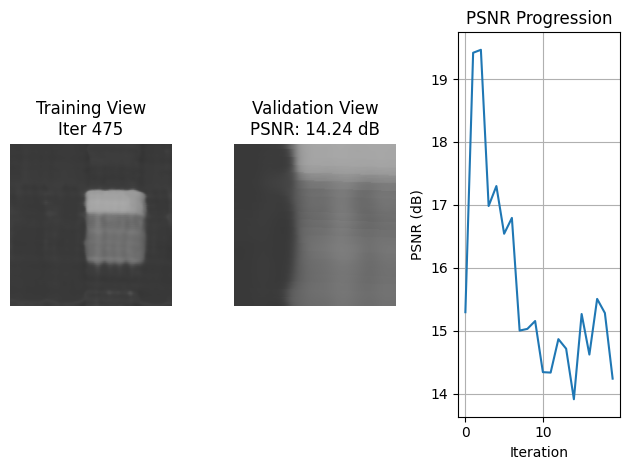

Iter 0475 | Loss: 0.0025 | PSNR: 14.24 | Time: 0.1m


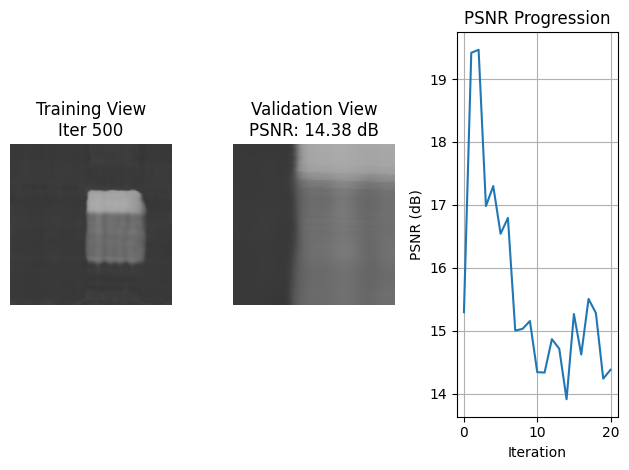

Iter 0500 | Loss: 0.0028 | PSNR: 14.38 | Time: 0.1m


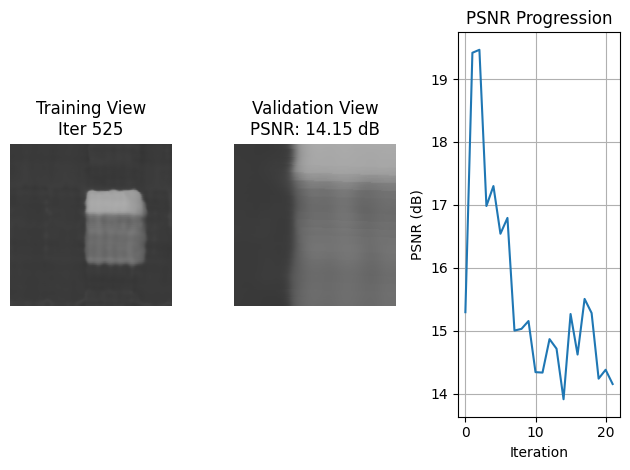

Iter 0525 | Loss: 0.0022 | PSNR: 14.15 | Time: 0.1m


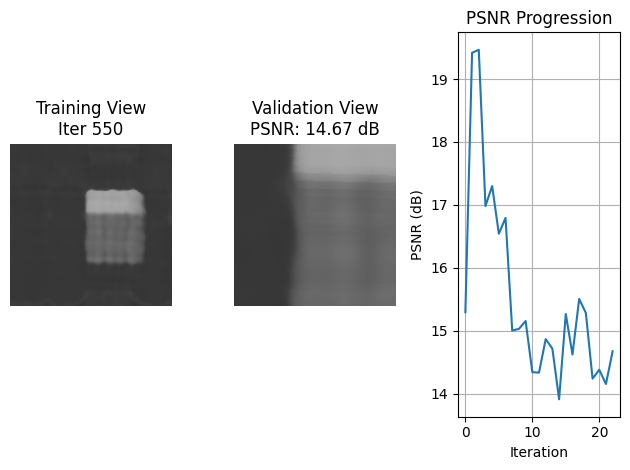

Iter 0550 | Loss: 0.0026 | PSNR: 14.67 | Time: 0.1m


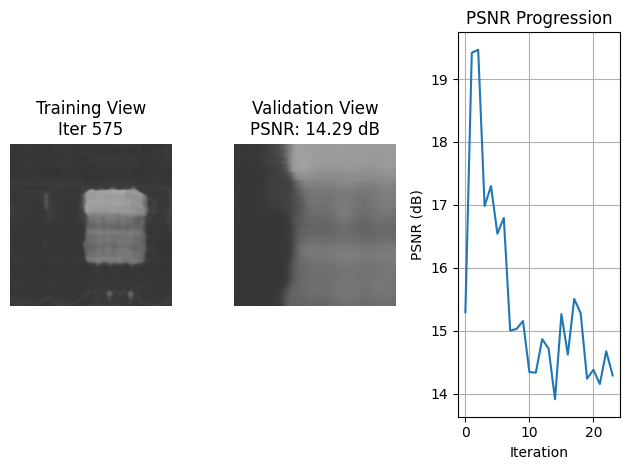

Iter 0575 | Loss: 0.0036 | PSNR: 14.29 | Time: 0.1m


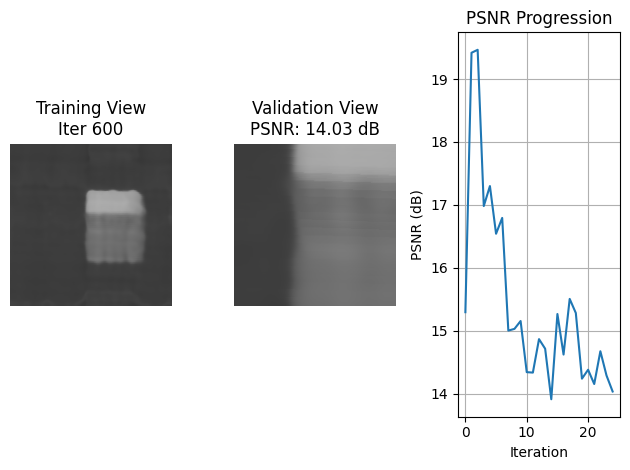

Iter 0600 | Loss: 0.0028 | PSNR: 14.03 | Time: 0.1m


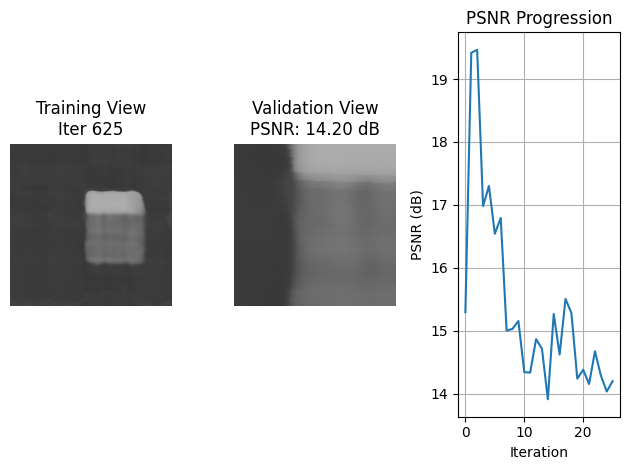

Iter 0625 | Loss: 0.0024 | PSNR: 14.20 | Time: 0.1m


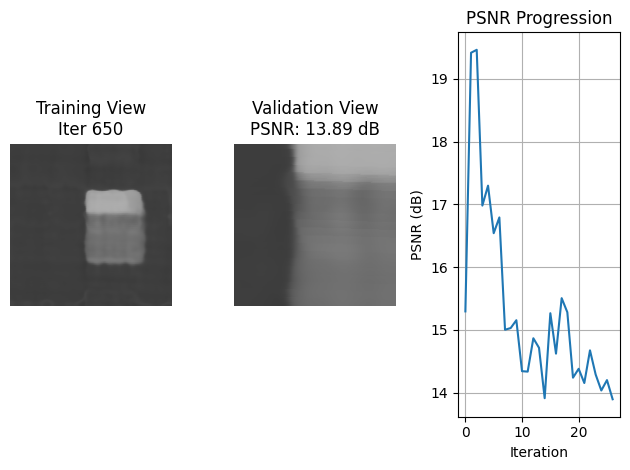

Iter 0650 | Loss: 0.0085 | PSNR: 13.89 | Time: 0.1m


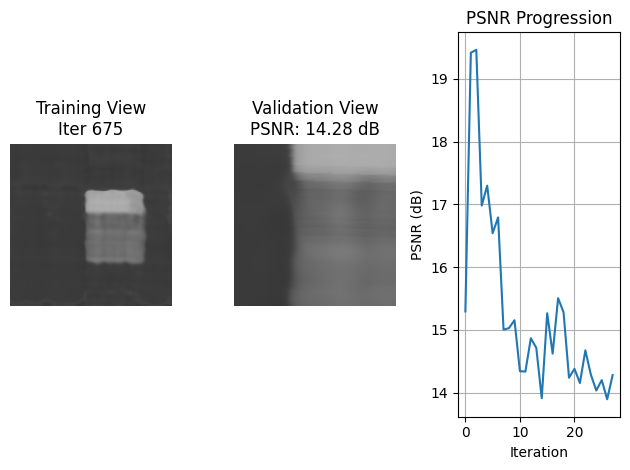

Iter 0675 | Loss: 0.0037 | PSNR: 14.28 | Time: 0.1m


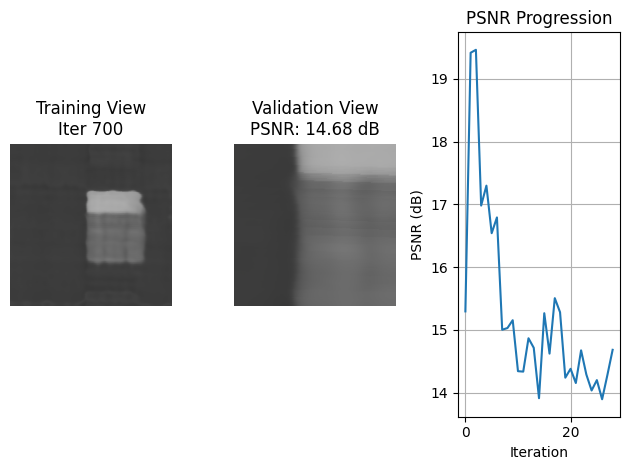

Iter 0700 | Loss: 0.0010 | PSNR: 14.68 | Time: 0.1m


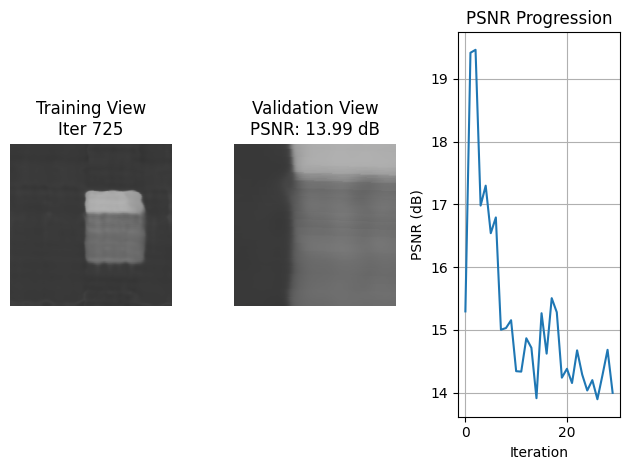

Iter 0725 | Loss: 0.0011 | PSNR: 13.99 | Time: 0.1m


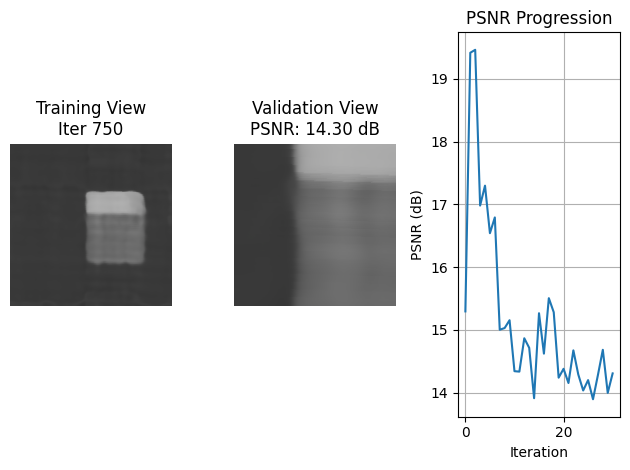

Iter 0750 | Loss: 0.0010 | PSNR: 14.30 | Time: 0.1m


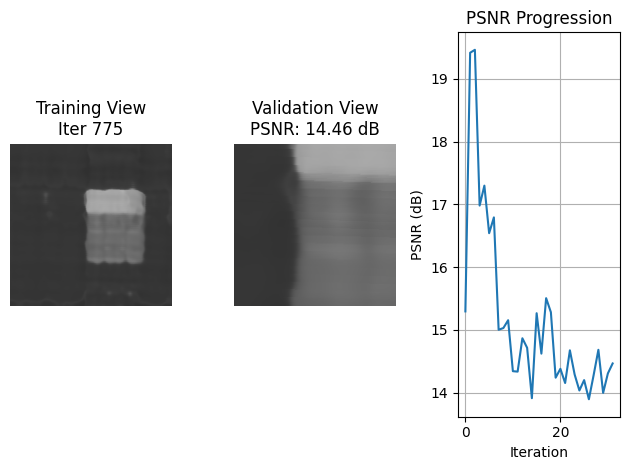

Iter 0775 | Loss: 0.0038 | PSNR: 14.46 | Time: 0.1m


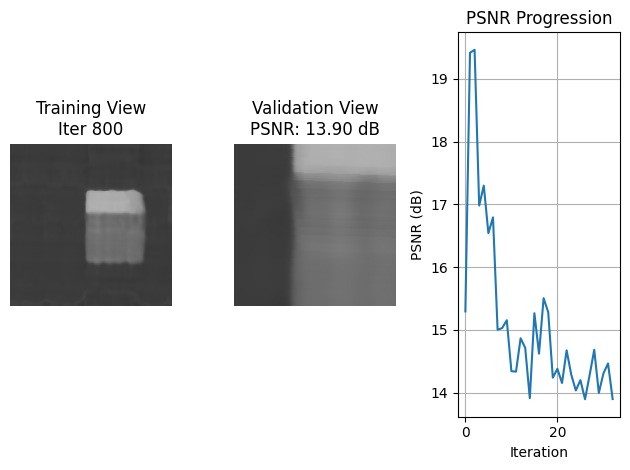

Iter 0800 | Loss: 0.0020 | PSNR: 13.90 | Time: 0.1m


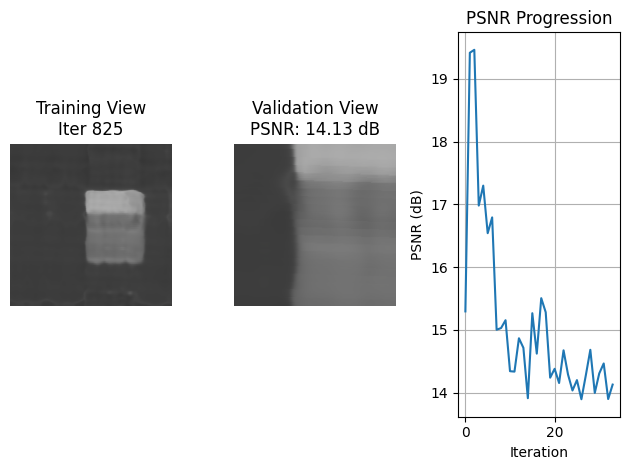

Iter 0825 | Loss: 0.0012 | PSNR: 14.13 | Time: 0.1m


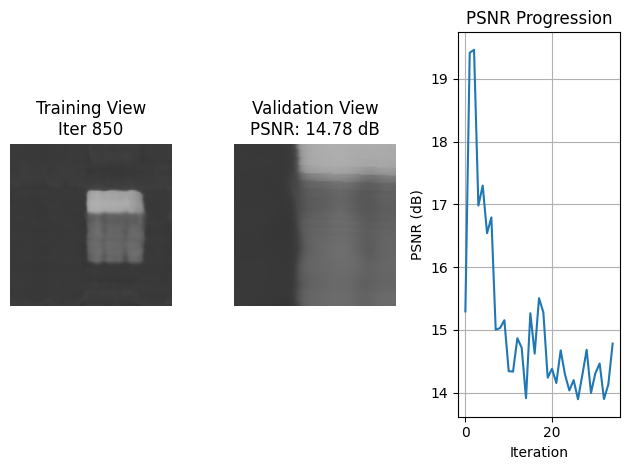

Iter 0850 | Loss: 0.0086 | PSNR: 14.78 | Time: 0.1m


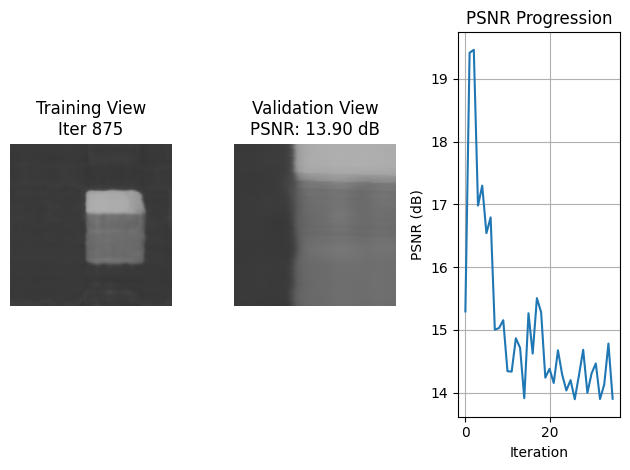

Iter 0875 | Loss: 0.0007 | PSNR: 13.90 | Time: 0.1m


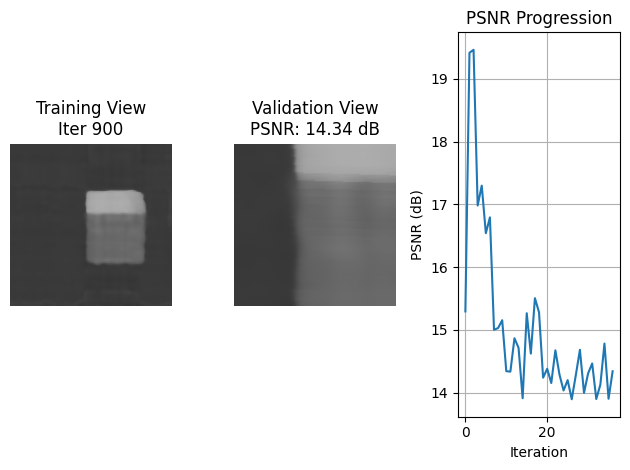

Iter 0900 | Loss: 0.0010 | PSNR: 14.34 | Time: 0.1m


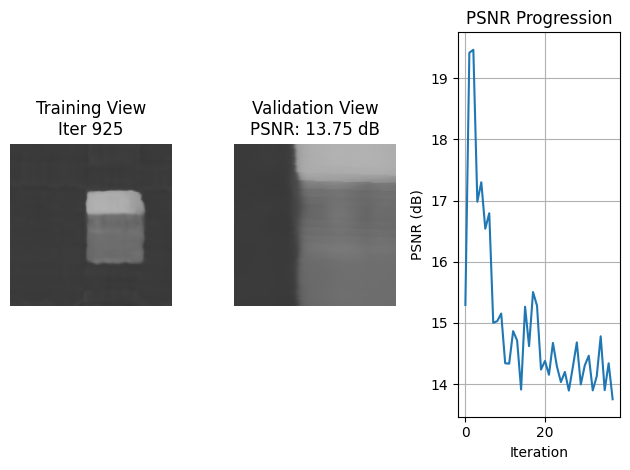

Iter 0925 | Loss: 0.0018 | PSNR: 13.75 | Time: 0.1m


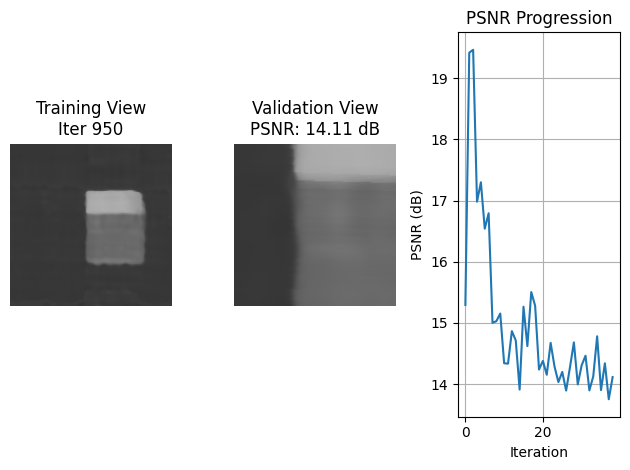

Iter 0950 | Loss: 0.0018 | PSNR: 14.11 | Time: 0.1m


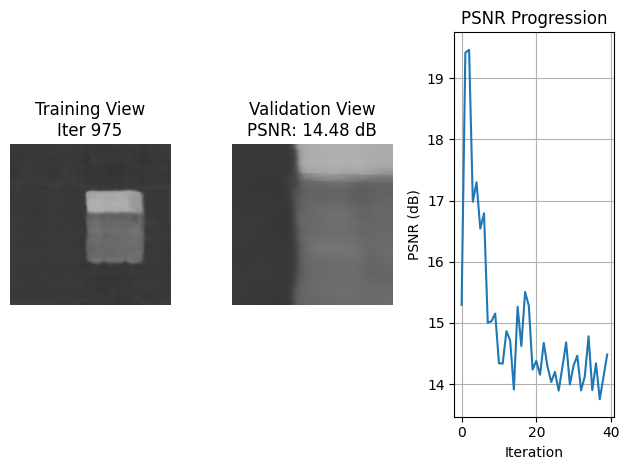

Iter 0975 | Loss: 0.0042 | PSNR: 14.48 | Time: 0.1m


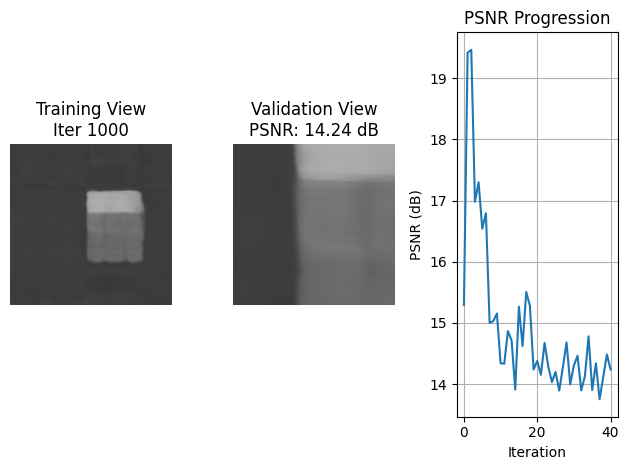

Iter 1000 | Loss: 0.0013 | PSNR: 14.24 | Time: 0.1m
Training Completed Successfully
Model saved successfully


In [44]:
import torch
import time
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from torch.nn import functional as F
import os

# Memory configuration
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

class AcademicNeRF(torch.nn.Module):
    def __init__(self, L_embed=10, D=8, W=256):  # Increased capacity
        super().__init__()
        input_dim = 3 * (1 + 2 * L_embed)
        self.embedder = torch.nn.Sequential(
            PositionalEncoder(L_embed),
            torch.nn.Linear(input_dim, W),
            *[ResidualBlock(W) for _ in range(D)],  # Deeper network
            torch.nn.Linear(W, W)  # Additional layer
        )
        self.output = torch.nn.Linear(W, 4)

    def forward(self, x):
        return self.output(self.embedder(x))

class PositionalEncoder(torch.nn.Module):
    def __init__(self, L_embed):
        super().__init__()
        self.register_buffer('freq_bands', 2.**torch.arange(L_embed))

    def forward(self, x):
        encoded = [x]
        for freq in self.freq_bands:
            encoded.extend([torch.sin(freq*x), torch.cos(freq*x)])
        return torch.cat(encoded, dim=-1)

class ResidualBlock(torch.nn.Module):
    def __init__(self, features):
        super().__init__()
        self.linear = torch.nn.Linear(features, features)
        self.norm = torch.nn.LayerNorm(features)

    def forward(self, x):
        return x + F.relu(self.norm(self.linear(x)))

def secure_dataset_load(processed_dir):
    try:
        dataset_files = sorted(
            Path(processed_dir).glob("nerf_processed_v3.2_*.pt"),
            key=lambda f: f.stat().st_ctime,
            reverse=True
        )
        if not dataset_files:
            raise FileNotFoundError("No valid academic datasets found")

        data = torch.load(dataset_files[0], map_location='cpu', weights_only=True)

        required_structure = {
            'metadata': {'version': '3.2', 'resolution': str, 'security': dict},
            'dataset': {'train': ['images', 'poses', 'H', 'W', 'focal'], 'val': ['images', 'poses', 'H', 'W', 'focal']}
        }

        errors = []
        for key in required_structure:
            if key not in data:
                errors.append(f"Missing root key: {key}")
        if 'metadata' in data:
            if data['metadata'].get('version') != '3.2':
                errors.append("Version mismatch detected")
            if 'security' not in data['metadata']:
                errors.append("Missing security metadata")
        if 'dataset' in data:
            for split in ['train', 'val']:
                if split not in data['dataset']:
                    errors.append(f"Missing {split} split")
                else:
                    for field in required_structure['dataset'][split]:
                        if field not in data['dataset'][split]:
                            errors.append(f"Missing {field} in {split} split")

        if errors:
            raise RuntimeError(f"Validation Failed:\n" + "\n".join(f"- {e}" for e in errors))

        return data['dataset']

    except Exception as e:
        print(f"\033[91mSecurity Alert: {str(e)}\033[0m")
        return None

def get_rays(H, W, focal, c2w, device='cpu'):
    """Memory-optimized ray generation with FP16"""
    with torch.no_grad():
        i, j = torch.meshgrid(
            torch.linspace(0, W-1, W, device='cpu'),
            torch.linspace(0, H-1, H, device='cpu'),
            indexing='xy'
        )
        dirs = torch.stack([(i - W/2)/focal, -(j - H/2)/focal, -torch.ones_like(i)], -1)
        rays_d = torch.einsum('ij,hwj->hwi', c2w[:3,:3].cpu(), dirs)
        rays_o = c2w[:3,-1].cpu().expand(rays_d.shape)
    return rays_o.half().to(device), rays_d.half().to(device)

def render_rays(model, rays_o, rays_d, near=2.0, far=6.0, N_samples=24, chunk=1024):
    """Memory-safe rendering with double chunking"""
    rays_o = rays_o.reshape(-1, 3)
    rays_d = rays_d.reshape(-1, 3)

    z_vals = torch.linspace(near, far, N_samples, device=rays_o.device)
    outputs = []

    for i in range(0, rays_o.shape[0], chunk):
        rays_o_chunk = rays_o[i:i+chunk]
        rays_d_chunk = rays_d[i:i+chunk]
        chunk_output = []

        sub_chunk = 256
        for j in range(0, rays_o_chunk.shape[0], sub_chunk):
            with torch.cuda.amp.autocast():
                pts = rays_o_chunk[j:j+sub_chunk, None] + \
                      rays_d_chunk[j:j+sub_chunk, None] * \
                      z_vals[None, :, None]

                pts = pts.contiguous().reshape(-1, 3)
                raw = model(pts)
                chunk_output.append(raw.reshape(-1, N_samples, 4))

                del pts, raw
                torch.cuda.empty_cache()

        outputs.append(torch.cat(chunk_output).float())
        del rays_o_chunk, rays_d_chunk, chunk_output
        torch.cuda.empty_cache()

    raw = torch.cat(outputs, dim=0)
    del outputs

    sigma_a = F.relu(raw[..., 3])
    rgb = torch.sigmoid(raw[..., :3])

    dists = z_vals[1:] - z_vals[:-1]
    dists = torch.cat([dists, torch.full_like(z_vals[:1], 1e10)])

    alpha = 1 - torch.exp(-sigma_a * dists)
    weights = alpha * torch.cumprod(1 - alpha + 1e-10, -1)

    return (
        torch.sum(weights[..., None] * rgb, -2),
        torch.sum(weights * z_vals, -1),
        weights.sum(-1)
    )

def train_nerf_academic(processed_dir, num_iters=2000, lr=1e-4, device='cuda', batch_size=1):
    torch.cuda.empty_cache()

    dataset = secure_dataset_load(processed_dir)
    if dataset is None:
        return None

    # Downsample configuration
    H = dataset['train']['H'] // 2
    W = dataset['train']['W'] // 2
    focal = dataset['train']['focal'] * 2

    # Preprocess training data
    train_images = [F.interpolate(img.permute(2,0,1).unsqueeze(0),
                    (H, W), mode='bilinear').squeeze(0).permute(1,2,0)
                    for img in dataset['train']['images']]
    train_poses = [pose.to(device) for pose in dataset['train']['poses']]

    # Initialize model and optimizer
    model = AcademicNeRF().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scaler = torch.cuda.amp.GradScaler()

    psnr_history = []
    t_start = time.time()

    # Initialize visualization figure
    plt.figure(figsize=(18, 6))

    for iter in range(num_iters + 1):
        model.train()
        optimizer.zero_grad(set_to_none=True)

        # Random training sample
        idx = torch.randint(len(train_images), (1,)).item()
        pose = train_poses[idx]

        # Generate rays on CPU
        rays_o, rays_d = get_rays(H, W, focal, pose.cpu(), device='cpu')

        loss = 0
        for _ in range(4):  # Process in 4 sub-batches
            idx_rays = torch.randint(H*W, (batch_size//4,))

            # Move data to device in FP16
            rays_o_batch = rays_o.reshape(-1, 3)[idx_rays].to(device)
            rays_d_batch = rays_d.reshape(-1, 3)[idx_rays].to(device)
            target_batch = train_images[idx].reshape(-1, 3)[idx_rays].to(device).half()

            with torch.cuda.amp.autocast():
                rgb, _, _ = render_rays(model, rays_o_batch, rays_d_batch, N_samples=24)
                loss += F.mse_loss(rgb, target_batch)

            # Cleanup
            del rays_o_batch, rays_d_batch, target_batch, rgb
            torch.cuda.empty_cache()

        # Optimization step
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Validation and visualization
        if iter % 25 == 0:
            model.eval()
            with torch.no_grad():
                # Render training view
                train_rays_o, train_rays_d = get_rays(H, W, focal, pose.cpu(), device=device)
                rgb_train, _, _ = render_rays(model, train_rays_o, train_rays_d, N_samples=24)

                # Render validation view
                val_H, val_W = H//2, W//2
                val_pose = dataset['val']['poses'][0].cpu()
                val_rays_o, val_rays_d = get_rays(val_H, val_W, focal*2, val_pose, device=device)
                rgb_val, _, _ = render_rays(model, val_rays_o, val_rays_d, N_samples=24)

                # Prepare targets
                train_img = train_images[idx].cpu().numpy()
                val_img = F.interpolate(dataset['val']['images'][0].permute(2,0,1).unsqueeze(0),
                                      (val_H, val_W)).squeeze(0).permute(1,2,0).cpu().numpy()

                # Calculate PSNR
                val_target = torch.from_numpy(val_img.reshape(-1, 3)).to(device)
                psnr = -10. * torch.log10(F.mse_loss(rgb_val, val_target))
                psnr_history.append(psnr.item())

                # Visualization
                plt.clf()

                # Training view comparison
                plt.subplot(1, 3, 1)
                plt.imshow(np.clip(rgb_train.cpu().numpy().reshape(H, W, 3), 0, 1))
                plt.title(f"Training View\nIter {iter}")
                plt.axis('off')

                # Validation view comparison
                plt.subplot(1, 3, 2)
                plt.imshow(np.clip(rgb_val.cpu().numpy().reshape(val_H, val_W, 3), 0, 1))
                plt.title(f"Validation View\nPSNR: {psnr:.2f} dB")
                plt.axis('off')

                # PSNR progression
                plt.subplot(1, 3, 3)
                plt.plot(psnr_history)
                plt.title("PSNR Progression")
                plt.xlabel("Iteration")
                plt.ylabel("PSNR (dB)")
                plt.grid(True)

                # Display and flush
                plt.tight_layout()
                plt.show()
                plt.pause(0.001)  # Needed for plot updates in notebooks

            print(f"Iter {iter:04d} | Loss: {loss.item():.4f} | PSNR: {psnr:.2f} | Time: {(time.time()-t_start)/60:.1f}m")
            t_start = time.time()

    print("\033[92mTraining Completed Successfully\033[0m")
    return model

if __name__ == "__main__":
    PROCESSED_DIR = "/content/drive/MyDrive/DESMAI_TALIYAJOSEPH_2025/Tinynerf/processed"
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Fresh start with memory cleanup
    if torch.cuda.is_available():
        torch.cuda.reset_peak_memory_stats()
        torch.cuda.empty_cache()

    # Start training
    model = train_nerf_academic(
        processed_dir=PROCESSED_DIR,
        num_iters=1000,
        lr=5e-4,
        device=DEVICE,
        batch_size=128
    )

    # Save final model
    if model:
        torch.save(model.state_dict(), "DESMAI_NeRF_Model.pth")
        print("\033[92mModel saved successfully\033[0m")

In [45]:
%matplotlib inline
from ipywidgets import interactive, widgets
import torch
import numpy as np
import matplotlib.pyplot as plt

# Load dataset
PROCESSED_DIR = "/content/drive/MyDrive/DESMAI_TALIYAJOSEPH_2025/Tinynerf/processed"
dataset = secure_dataset_load(PROCESSED_DIR)
if dataset is None:
    raise ValueError("Failed to load dataset - check your processed directory path")

# Set resolution parameters from training config
H = dataset['train']['H'] // 2
W = dataset['train']['W'] // 2
focal = dataset['train']['focal'] * 2

def pose_spherical(theta, phi, radius):
    def trans_t(t):
        return torch.tensor([
            [1,0,0,0],
            [0,1,0,0],
            [0,0,1,t],
            [0,0,0,1]
        ], dtype=torch.float32)

    def rot_phi(phi):
        return torch.tensor([
            [1,0,0,0],
            [0,torch.cos(phi),-torch.sin(phi),0],
            [0,torch.sin(phi), torch.cos(phi),0],
            [0,0,0,1]
        ], dtype=torch.float32)

    def rot_theta(th):
        return torch.tensor([
            [torch.cos(th),0,-torch.sin(th),0],
            [0,1,0,0],
            [torch.sin(th),0, torch.cos(th),0],
            [0,0,0,1]
        ], dtype=torch.float32)

    c2w = trans_t(radius)
    c2w = rot_phi(torch.deg2rad(torch.tensor(phi, dtype=torch.float32))) @ c2w
    c2w = rot_theta(torch.deg2rad(torch.tensor(theta, dtype=torch.float32))) @ c2w

    # Fixed dtype for correction matrix
    correction = torch.tensor([
        [-1,0,0,0],
        [0,0,1,0],
        [0,1,0,0],
        [0,0,0,1]
    ], dtype=torch.float32)

    c2w = correction @ c2w
    return c2w

def f(theta, phi, radius):
    device = next(model.parameters()).device

    with torch.no_grad():
        c2w = pose_spherical(theta, phi, radius).to(device)
        rays_o, rays_d = get_rays(H, W, focal, c2w[:3,:4])

        # Convert to half precision for memory efficiency
        rays_o = rays_o.half().to(device)
        rays_d = rays_d.half().to(device)

        rgb, _, _ = render_rays(model, rays_o, rays_d,
                              near=2., far=6.,
                              N_samples=24,
                              chunk=1024)

        img = rgb.float().cpu().numpy()
        img = np.clip(img, 0, 1)

    plt.figure(figsize=(12, 6))
    plt.imshow(img)
    plt.title(f"θ: {theta:.1f}° | φ: {phi:.1f}° | Radius: {radius:.1f}")
    plt.axis('off')
    plt.show()

    # Memory cleanup
    del rays_o, rays_d, rgb, c2w
    torch.cuda.empty_cache()

# Create interactive widgets with better layout
sldr = lambda v, mi, ma: widgets.FloatSlider(
    value=v,
    min=mi,
    max=ma,
    step=1.0,
    continuous_update=False,
    layout=widgets.Layout(width='500px')
)

interactive_plot = interactive(
    f,
    theta=sldr(100.0, 0.0, 360.0),
    phi=sldr(-30.0, -90.0, 0.0),
    radius=sldr(4.0, 3.0, 5.0)
)

# Adjust output display
output = interactive_plot.children[-1]
output.layout.height = '650px'
output.layout.width = '850px'

interactive_plot

interactive(children=(FloatSlider(value=100.0, continuous_update=False, description='theta', layout=Layout(wid…

In [46]:
from tqdm.notebook import tqdm
import imageio

# Video parameters
N_samples = 24
chunk_size = 1024
fps = 30

# Get device from model
device = next(model.parameters()).device

# Calculate aligned resolution (divisible by 16)
base_H = int(dataset['train']['H'] * 0.5)
base_W = int(dataset['train']['W'] * 0.5)
focal = dataset['train']['focal'] * 2

# Align to nearest multiple of 16
def align16(x):
    return (x + 15) // 16 * 16

H, W = align16(base_H), align16(base_W)
print(f"Using video resolution: {W}x{H} (aligned for codec compatibility)")

frames = []
for th in tqdm(np.linspace(0., 360., 120, endpoint=False)):
    c2w = pose_spherical(th, -30., 4.).to(device)

    # Generate rays with aligned resolution
    rays_o, rays_d = get_rays(H, W, focal, c2w[:3,:4])

    # Render frame
    with torch.no_grad():
        rgb, _, _ = render_rays(model,
                              rays_o.half().to(device),
                              rays_d.half().to(device),
                              near=2.,
                              far=6.,
                              N_samples=N_samples,
                              chunk=chunk_size)

    # Reshape and pad if needed
    img = rgb.cpu().numpy().reshape(H, W, 3)
    img = np.clip(img, 0, 1)

    # Add to frames
    frames.append((255 * img).astype(np.uint8))

    # Cleanup
    del rays_o, rays_d, rgb, c2w
    torch.cuda.empty_cache()

# Save video with correct dimensions
video_path = 'nerf_reconstruction.mp4'
imageio.mimwrite(video_path, frames, fps=fps, macro_block_size=None)

print(f"\n✅ Video successfully saved to {video_path}")

Using video resolution: 400x400 (aligned for codec compatibility)


  0%|          | 0/120 [00:00<?, ?it/s]

<ipython-input-44-288650d56189>:121: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



✅ Video successfully saved to nerf_reconstruction.mp4


In [47]:
from IPython.display import HTML, display
from base64 import b64encode

# Customize these parameters
VIDEO_WIDTH = 800  # Set between 400-1000
AUTOPLAY = True    # Set to False if you want manual play
LOOP = True        # Set to False for single playthrough

try:
    # Load and display video
    video_path = 'nerf_reconstruction.mp4'  # Match your output filename
    mp4 = open(video_path,'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

    display(HTML(f"""
    <div style="margin:20px">
        <h3 style="color:#2e86c1">NeRF Reconstruction Video</h3>
        <video width="{VIDEO_WIDTH}" controls {'autoplay' if AUTOPLAY else ''} {'loop' if LOOP else ''}>
            <source src="{data_url}" type="video/mp4">
        </video>
        <p style="margin-top:10px">
            <a href="{data_url}" download="{video_path}">Download Video</a>
        </p>
    </div>
    """))

except FileNotFoundError:
    print(f"❌ Error: Video file '{video_path}' not found. Please run the video rendering cell first.")
except Exception as e:
    print(f"❌ Unexpected error: {str(e)}")